# Recurrent Neural Networks

RNNs are a family of neural networks for processing sequential data. 

We have seen how convolutional neural networks are specialized in processing a grid of values $X$. In the same way, RNNs are specialized in processing a sequence of values $x^{(1)}, x^{(2)}, \dots, x^{(\tau)}$. 

To go from MLP to RNN, we again need to take advantage of parameter sharing so that we can process sequences of arbitrary length (just like we did with CNNs for images of arbitrary size). In other words, if we used an MLP, the input layer has a fixed dimensionality, which we do not want. Some sequences may be shorter or longer than other sequences. 

Of course, we could use a 1-D convolution operation on a sequence of data, for which parameter sharing is still applied and this approach is scalable to arbitrary sequence lengths. This is actually the basis for [time-delay networks](https://en.wikipedia.org/wiki/Time_delay_neural_network). However, this type of parameter sharing is not the same as that of RNNs. Using a 1-D convolution means that the output is a product of the input and a small neighbourhood around the input at each time point of the sequence. RNNs instead compute the output based on every single input that came before a specific time step. 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

## Basic RNN module

Maps input sequence to output sequence using update equations for each time step $t=1$ to $t = \tau$
\begin{align*}
    \textbf{a}^{(t)} &= \textbf{b} + \textbf{W}\;\textbf{h}^{(t-1)} + \textbf{U}\;\textbf{x}^{(t)}\\
    \textbf{h}^{(t)} &= \text{tanh}(\textbf{a}^{(t)})\\
    \hat{\textbf{y}}^{(t)} &= \textbf{c} + \textbf{V}\;\textbf{h}^{(t)}
\end{align*}
for 
- shared bias vectors $\textbf{b}, \textbf{c}$
- shared weight matrices:
  - $\textbf{W}$: hidden-to-hidden weights
  - $\textbf{U}$: input-to-hidden
  - $\textbf{V}$: hidden-to-output
- and input vectors $\textbf{x} \in \textbf{X}$

PyTorch handles the mathematics in an efficient way. In the following we define a custom torch module that contains the RNN as well as a linear layer followed by a softmax layer. This allows us to output a distribution of possible outputs for each sequence.   

In [7]:
class MyRNN(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        ##############################
        ### use nn.RNN to define a RNN module 
        ### with batch_first=True
        ### and other parameters  
        ### write code here
        ##############################
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        ##############################
        ### run RNN module supplied with X and H
        ### to get outputs and a new H
        ### write code here
        ##############################
        output, H = None, H
        return self.out_layer(output), H

In [8]:
rnn = MyRNN(
    num_inputs=1,
    num_hidden=20,
    num_outputs=5,
    n_layers=3
)

batch_size, seq_len, n_inputs = 32, 50, 1
x = torch.randn(batch_size, seq_len, n_inputs)

y, h = rnn(x)

x.shape, y.shape, h.shape

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([32, 50, 1]), torch.Size([32, 50, 5]), torch.Size([3, 32, 20]))

## Sequence Dataset

Since we operate on sequences when using RNNs, we will be using a dataset where the data is ordered sequentially. 

Specifically, to showcase how to use RNNs, we will use a simple noisy sine wave as our time series. We denote the sequence length of the input sequence by $\tau$. 

- `src_X`: source input covariate sequence (simple enumeration for now $[\textbf{x}^{(0)}, \textbf{x}^{(1)}, \dots, \textbf{x}^{(T)}]$)

- `src_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)}]$)

- `tgt_X`: source target covariate sequence (simple enumeration for now $[\textbf{x}^{(T+1)}, \textbf{x}^{(T+2)}, \dots, \textbf{x}^{(T+\tau)}]$)

- `tgt_fX`: source input feature sequence (simple noisy sine wave $[\textbf{y}^{(T+1)}, \textbf{y}^{(T+2)}, \dots, \textbf{y}^{(T+\tau)}]$)

Our learning problem becomes the following: 

Given `src_fX`, we want to predict `tgt_fX`, or in other words:
$$
    [\hat{\textbf{y}}^{(T)}, \hat{\textbf{y}}^{(T+1)}, \dots, \hat{\textbf{y}}^{(T+\tau)}] = \text{RNN}(\textbf{y}^{(0)}, \textbf{y}^{(1)}, \dots, \textbf{y}^{(T)})
$$

Of course, a more sophisticated sequence model would consider both `src_X` and `src_fX` by aggregating these vectors and feeding it in the model. However, for simplicity, we will only use the feature sequence and only predict the feature sequence. 

In [9]:
from torch.utils.data import Dataset

# base class for an arbitrary sequence dataset
# key idea: samples are generated by sliding window over the entire sequence
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        X: torch.Tensor,
        fX: torch.Tensor,
        seq_len: int,
        shift: int
    ):
        """
        :param X: time steps (covariates)
        :param fX: features per time step
        :param seq_len: length of each sequence example in dataset
        :param shift: number of steps to shift the target values
        """
        self.seq_len = seq_len
        self.shift = shift
        self.X = X
        self.fX = fX

    def __getitem__(self, index):

        sample = (
            self.X[index : index + self.seq_len],
            self.fX[index : index + self.seq_len],
            self.X[index + self.seq_len : index + self.seq_len + self.shift],
            self.fX[index + self.seq_len : index + self.seq_len + self.shift],
        )
        return sample

    def __len__(self):
        return len(self.X) - self.seq_len - self.shift

In [125]:
# specific time series dataset of a noisy sine wave  
class SineSyntheticDataset(TimeSeriesDataset):
    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        alpha: float = 0.1,
        noise: float = 0.1
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)
        fX = torch.sin(alpha * X) + torch.randn_like(X) * noise
        super().__init__(X, fX, seq_len, shift)

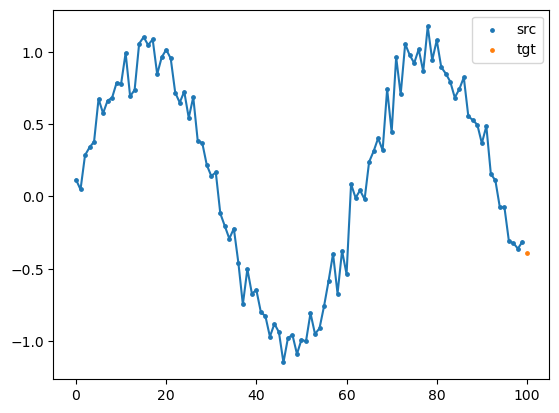

In [106]:
# let's test our dataset
dataset = SineSyntheticDataset(
    len_timeseries=5000, 
    seq_len=100,
    shift=1,
    alpha=0.1,
    noise=0.1
)

##############################
### take a sample from dataset 
### and plot src_x, src_fx
### and plot tgt_x, tgt_fx
### write code here
##############################

## Define train and validation steps

It is good practice to encapsulate a single training and validation step in their own separate functions. 

Notice the differences between train/valid steps:
- `train_step` trains for a single epoch over a given dataloader, where the optimizer is used to perform gradient descent. Additionally, the gradients are clipped as to ensure that gradients do not explode. 
- `valid_step` validates for a single epoch over a given dataloader, without optimizer and within a `no_grad()` context so that no gradients are calculated. 

We use the MSE loss in this case to make single point predictions. The MSE loss implicitly regularizes the predictions such that the predictions converge to the mean prediction. In the case of volatile time series, the MSE loss may not be desired, due to the large variance of the volatility in the sequences. The MSE loss converges to the mean, meaning that predictions will deviate too much from the target. Instead, the Mean Absolute Error (MAE) could pose as an alternative, because the MAE converges to the median (instead of the mean). The median is a reliable averaging metric in situations where there are a lot of outliers (e.g., in volatile time series). 

If the desired output instead should be probabilistic, then we need to predict an interval. In this case, we can use Quantile loss, where we predict different percentiles of the output. Common quantiles are `[0.1, 0.5, 0.9]`, which means that we predict the $10\%$, $50\%$, $90\%$ quantiles. This is a nice option, as it provides some interpretability with respect to how much the model is certain about its predictions. Also notice that the $50\%$ quantile is the same as the median, i.e., it is the same as the MAE.

In the following, we simply use the MSE loss. 

In [107]:
from torch.utils.data import DataLoader

def train_step(
        model: nn.Module, 
        dataloader: DataLoader, 
        optimizer: torch.optim,
        shift: int, 
        device: torch.device,
        grad_clip_val: int = 1
    ):
    model.train()
    batch_loss = []
    for _, batch_X, _, batch_y in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        y_pred, _ = model(batch_X)
        loss = F.mse_loss(y_pred[:, -shift:], batch_y)

        loss.backward()
        ##############################
        ### apply gradient clipping to the model parameters
        ### use torch.nn.utils.clip_grad_norm_ with the grad_clip_val
        ### write code here
        ##############################
        optimizer.step()

        batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

def valid_step(
        model: nn.Module, 
        dataloader: DataLoader,
        shift: int, 
        device: torch.device,
    ):
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for _, batch_X, _, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            y_pred, _ = model(batch_X)
            loss = F.mse_loss(y_pred[:, -shift:], batch_y)

            batch_loss.append(loss.detach().item())

    return np.sum(batch_loss) / len(batch_loss)

## Setup + train loop

Let's define some constants 

In [109]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 20
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

We create a synthetic sine wave dataset with some added noise. We split this time series in 3 parts, i.e., training part, validation part, and test part. 

- `train_set` consists of the first 80 percent of the time series and will be used to optimize our model
- `valid_set` consists of the next 10 percent of the time series and will be used to monitor whether the model is over/underfitting
- `test_set` consists of the last 10 percent of the time series and will be used to test the model **once** after training has finished. We will also use this set for predictions.

In [111]:
from torch.utils.data import DataLoader

dataset = SineSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    alpha=0.1,
    noise=0.1
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Let's train the model and plot the loss curves

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch=0	train_loss=0.3881729913334693	valid_loss=0.2784332590443747
epoch=1	train_loss=0.173774108050331	valid_loss=0.10117730072566442
epoch=2	train_loss=0.05429552107929222	valid_loss=0.014144871117813247
epoch=3	train_loss=0.015039623820132787	valid_loss=0.01383878437003919
epoch=4	train_loss=0.01470118468146651	valid_loss=0.013227652226175581
epoch=5	train_loss=0.014242873572173619	valid_loss=0.013042822613247804
epoch=6	train_loss=0.013910744804888964	valid_loss=0.013150196788566453
epoch=7	train_loss=0.013714655332507627	valid_loss=0.01281980997217553
epoch=8	train_loss=0.013628929222543393	valid_loss=0.013072724720197064
epoch=9	train_loss=0.013448145781313219	valid_loss=0.012113118012036597
epoch=10	train_loss=0.013291578184092236	valid_loss=0.012115475056426865
epoch=11	train_loss=0.013204770726001552	valid_loss=0.011786912967051779
epoch=12	train_loss=0.013006476099572836	valid_loss=0.011993672432644027
epoch=13	train_loss=0.012853103209166758	valid_loss=0.011544889371309961


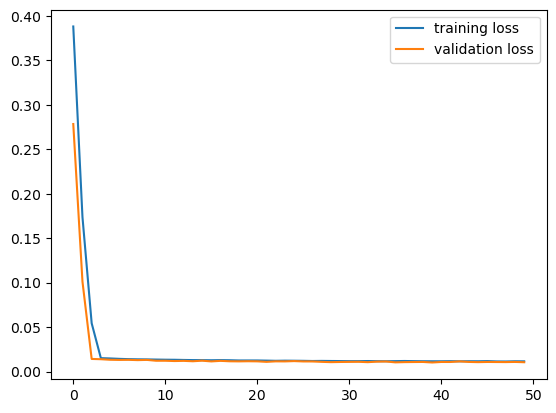

In [112]:
rnn = MyRNN(
    num_inputs=1, 
    num_hidden=N_HIDDEN,
    num_outputs=1, 
    n_layers=N_LAYERS,
    dropout=DROPOUT_RATE, 
).to(DEVICE)

optim = torch.optim.Adam(rnn.parameters(), LEARNING_RATE)

train_losses, valid_losses = [], []

for i in range(EPOCHS):
    
    ##############################
    ### call the train_step function and store the train_loss
    ### write code here
    ##############################

    
    ##############################
    ### call the valid_step function and store the validation_loss
    ### write code here
    ##############################
    
    print(f"epoch={i}\ttrain_loss={train_losses[-1]}\tvalid_loss={valid_losses[-1]}")

plt.plot(train_losses, label="training loss")
plt.plot(valid_losses, label="validation loss")
plt.legend()

Since the RNN model takes a sequence as its input and outputs the next value, we can make auto-regressive predictions. This means that we take the prediction and concatenate it to our input 

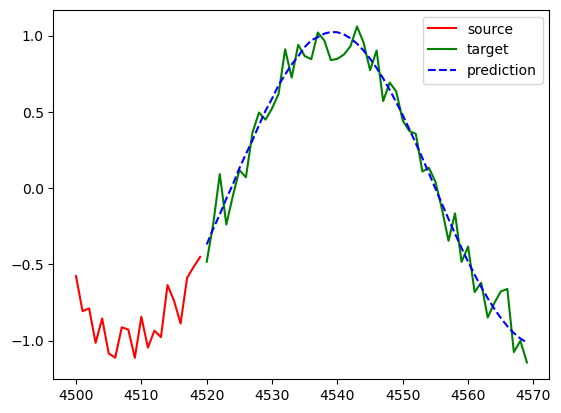

In [117]:
idx = 0
horizon = 50

src_x, src_fx, tgt_x, tgt_fx = test_set[idx]

output = src_fx.flatten().tolist()
tgt_X, tgt_fX = [], []


with torch.no_grad():

    for i in range(horizon):
        
        _, _, tgt_x, tgt_fx = test_set[idx+i]

        ##############################
        ### take last SEQ_LEN values of output
        ### predict using rnn model
        ### append last value of prediction to output
        ### write code here
        ##############################

        tgt_X.append(tgt_x.item())
        tgt_fX.append(tgt_fx.item())

plt.plot(src_x, src_fx, 'r', label='source')
plt.plot(tgt_X, tgt_fX, 'g', label='target')
plt.plot(tgt_X, output[len(src_fx):], '--b', label='prediction')
plt.legend()

# Long Short-Term Memory (LSTM)

The original RNN model suffers from so-called ``Long-Term Dependencies''. The basic problem is that given a long sequence, the gradients of the model parameters of this sequence tend to either vanish (most of the time) or explode (rarely, but with much damage to the optimization process). Vanishing/exploding gradients occur because the (simplified) recurrence relationship $\mathbf{h}^{(t)} = \mathbf{W}\; \mathbf{h}^{(t-1)}$ is applied many times in longer sequences. As a result, in the unfolded RNN, many multiplication operations are performed. This leads to again many multiplications during backpropagation. 

Now if we consider a value $w$ which is between zero and one, then in the limit $w^n \rightarrow 0$ as $n$ approaches $\infty$. If instead $w > 1$, then in the limit $w^n \rightarrow \infty$ as $n$ approaches $\infty$. This is precisely where both the vanishing/exploding gradients come from. This problem is particular to RNNs because of this recurrence relationship where we multiply the same weights by itself.  

Even if we assume that the parameters of the RNN are learned to be stable (with gradients not vanishing nor exploding), the difficulty of long-term dependencies arises from the exponentially smaller weights given to long-term interactions. As a result, in the forward pass, more weight is given to short-term dependencies, which may be detrimental when the sequence should attend to long-term dependencies.  

Some of these issues can be resolved by using **Gated RNNs**. These include the **Long Short-Term Memory (LSTM)** and the **Gated Recurrent Unit (GRU)**. For now let's consider the LSTM. The main idea is to introduce gates into the RNN similar to electrical gates that regulate the amount of voltage that is able to flow. This gating mechanism is also referred to as a *Leaky unit* (as the gate may leak a bit of information to the future). LSTM uses 3 gates, i.e., input, output, and forget gates. 
- **Input gate** decides what values of the hidden state to update
- **Output gate** decides what the new hidden state will be
- **Forget gate** decides what information to throw away (forget)

Let's see how we can implement the LSTM in PyTorch

In [118]:
class MyLSTM(nn.Module):
    def __init__(self, 
                 num_inputs: int, 
                 num_hidden: int, 
                 num_outputs: int, 
                 n_layers: int,
                 dropout: float = 0.5) -> None:
        super().__init__()
        self.lstm = nn.LSTM(num_inputs, num_hidden, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.out_layer = nn.LazyLinear(num_outputs)
    
    def forward(self, X: torch.Tensor, H: torch.Tensor = None):
        output, H = self.lstm(X, H)
        return self.out_layer(output), H

## Applying LSTM on simple noisy sine wave

Let's define some constants

In [ ]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 20
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Same as before, we create a synthetic sine wave dataset with some added noise. We split this time series in 3 parts, i.e., training part, validation part, and test part. 

- `train_set` consists of the first 80 percent of the time series and will be used to optimize our model
- `valid_set` consists of the next 10 percent of the time series and will be used to monitor whether the model is over/underfitting
- `test_set` consists of the last 10 percent of the time series and will be used to test the model **once** after training has finished. We will also use this set for predictions.

In [119]:
from torch.utils.data import DataLoader

##############################
### create dataset with same parameters as before
### split according to 0.8/0.1/0.1 distribution
### create train/test/validation data loaders
### write code here
##############################

Again, we train the model and monitor/plot the loss curves

In [ ]:
##############################
### create MyLSTM model with correct model parameters
### create optimizer (Adam or SGD)
### create training loop that calls train_step and valid_step functions
### write code here
##############################

Let's make some auto-regressive predictions

In [ ]:
##############################
### predict for a given horizon in an autoregressive manner for LSTM
### write code here
##############################

## Applying LSTM on a periodic curve time series

We re-define some constants

In [153]:
# Model constants
N_HIDDEN = 64
N_LAYERS = 1
DROPOUT_RATE = 0.0

# Training constants
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

# Dataset constants
LEN_TIMESERIES = 5000
SEQ_LEN = 128
SHIFT = 1

# check for possible GPU usage
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

This dataset is a bit more difficult as it is a combination of multiple sinusoidal functions. 

In [154]:
class PeriodicSyntheticDataset(TimeSeriesDataset):
    """
    :param len_timeseries: total length of entire time series
    :param A1, A2, A3: Control the timeseries periodic curves
    """

    def __init__(
        self,
        len_timeseries: int,
        seq_len: int,
        shift: int,
        noise: float,
        A1: float, A2: float,
        A3: float, A4: float,
    ):

        X = torch.arange(0, len_timeseries, dtype=torch.float32).reshape(-1, 1)

        c1 = A1 * torch.sin(torch.pi * X[:12] / 6)
        c2 = A2 * torch.sin(torch.pi * X[12:24] / 6)
        c3 = A3 * torch.sin(torch.pi * X[24:96] / 6)
        c4 = A4 * torch.sin(torch.pi * X[96:120] / 12)

        fX = torch.cat([c1, c2, c3, c4], dim=0)  # concat components
        fX = fX.repeat((len_timeseries + 120) // 120, 1)  # periodic repeats
        fX = fX[:len_timeseries]  # constrain total length
        fX = fX + noise * torch.randn(fX.shape)  # add noise

        super().__init__(X, fX, seq_len, shift)

In [155]:
from torch.utils.data import DataLoader

dataset = PeriodicSyntheticDataset(
    len_timeseries=LEN_TIMESERIES, 
    seq_len=SEQ_LEN,
    shift=SHIFT,
    noise=0.1,
    A1=0.4, A2=0.6, A3=0.03, A4=0.6
)

train_size = int(0.8 * LEN_TIMESERIES)
valid_size = int(0.1 * LEN_TIMESERIES)

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, LEN_TIMESERIES))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [ ]:
##############################
### take a sample from dataset 
### and plot src_x, src_fx
### and plot tgt_x, tgt_fx
### write code here
##############################

Let's train the model and plot the loss curves

In [ ]:
##############################
### create MyLSTM model with correct model parameters
### create optimizer (Adam or SGD)
### create training loop that calls train_step and valid_step functions
### write code here
##############################

In the below, we make auto-regressive predictions where you can see that the model somewhat learned the curving patterns. Since we are using batched SGD, you can see that we are not actively learning the noise, which is nice. 

In [ ]:
##############################
### predict for a given horizon in an autoregressive manner for LSTM
### write code here
##############################